# КРЕДИТНЫЙ СКОРИНГ

# 0. Описание проекта

Построение модели, предсказывающей вероятность дефолта по кредиту на основе данных по клиенту

# 1. Импорт библиотек

In [1]:
# необходимые библиотеки
from pandas import Series
import pandas as pd
import numpy as np

import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from datetime import datetime, timedelta

from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


# 2. Загрузка и предварительный осмотр данных

## 2.1. Загрузка данных

In [2]:
PATH_to_file = '/kaggle/input/sf-dst-scoring/'
train = pd.read_csv(PATH_to_file + 'train.csv')
test = pd.read_csv(PATH_to_file + 'test.csv')
sample_submission = pd.read_csv(PATH_to_file + 'sample_submission.csv')

In [3]:
# Для контроля зафиксируем размер тренировочного и тестового датасетов.
print('Размер тренировочного датасета: ', train.shape,
      'Размер тестового датасета: ', test.shape, 
      'Размер объединенного датасета: ', train.shape[0]+test.shape[0], sep='\n')

Размер тренировочного датасета: 
(73799, 19)
Размер тестового датасета: 
(36349, 18)
Размер объединенного датасета: 
110148


In [4]:
# Объединяем тренировочные и тестовые данные в один датасет.
train['train'] = 1 # помечаем тренировочные
test['train'] = 0 # помечаем тестовые
data = pd.concat([train, test], ignore_index=True)
data.sample(5)

client_id   app_date education sex  age car car_type  decline_app_cnt  \
298       104893  23APR2014       SCH   M   48   N        N                0   
52436      81839  29MAR2014       UGR   M   34   Y        N                1   
54746      11845  19JAN2014       GRD   M   24   N        N                0   
73452       3988  10JAN2014       SCH   F   33   N        N                0   
85890      87759  04APR2014       SCH   M   63   Y        Y                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
298            0  -1.344746                3             60             2   
52436          0  -2.140935                0             70             1   
54746          0  -2.272941                3             70             1   
73452          0  -2.081377                3             50             1   
85890          0  -2.736080                1             40             2   

       work_address  income  sna  first_time foreign_passport  default  train  
298               3   25000    1           4                N      0.0      1  
52436             1   40000    1           1                N      0.0      1  
54746             2   35000    1           3                Y      0.0      1  
73452             2   15000    1           3                N      0.0      1  
85890             3   40000    1           4                N      NaN      0

## 2.2. Описание полей:
* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

## 2.3. Общая информация о полях

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [6]:
data.describe()

client_id            age  decline_app_cnt      good_work  \
count  110148.000000  110148.000000    110148.000000  110148.000000   
mean    55074.500000      39.249410         0.273205       0.165514   
std     31797.133063      11.518063         0.799099       0.371645   
min         1.000000      21.000000         0.000000       0.000000   
25%     27537.750000      30.000000         0.000000       0.000000   
50%     55074.500000      37.000000         0.000000       0.000000   
75%     82611.250000      48.000000         0.000000       0.000000   
max    110148.000000      72.000000        33.000000       1.000000   

           score_bki  bki_request_cnt  region_rating   home_address  \
count  110148.000000    110148.000000  110148.000000  110148.000000   
mean       -1.904535         2.005002      56.751189       1.574945   
std         0.499397         2.266926      13.065923       0.527562   
min        -3.624586         0.000000      20.000000       1.000000   
25%        -2.260434         0.000000      50.000000       1.000000   
50%        -1.920823         1.000000      50.000000       2.000000   
75%        -1.567888         3.000000      60.000000       2.000000   
max         0.199773        53.000000      80.000000       3.000000   

        work_address          income            sna     first_time  \
count  110148.000000   110148.000000  110148.000000  110148.000000   
mean        2.497867    41012.648537       1.731588       2.765570   
std         0.687651    45399.735051       1.122652       1.010151   
min         1.000000     1000.000000       1.000000       1.000000   
25%         2.000000    20000.000000       1.000000       2.000000   
50%         3.000000    30000.000000       1.000000       3.000000   
75%         3.000000    48000.000000       2.000000       4.000000   
max         3.000000  1000000.000000       4.000000       4.000000   

            default          train  
count  73799.000000  110148.000000  
mean       0.126994       0.669999  
std        0.332968       0.470215  
min        0.000000       0.000000  
25%        0.000000       0.000000  
50%        0.000000       1.000000  
75%        0.000000       1.000000  
max        1.000000       1.000000

In [7]:
# Смотрим количество и долю пропусков в колонках:

n = 110148
for i in list(data.columns.values):
    num_of_null = data[i].isna().sum()
    print(i, '    ', num_of_null, ',', round(num_of_null/n*100, 1), '%')

client_id      0 , 0.0 %
app_date      0 , 0.0 %
education      478 , 0.4 %
sex      0 , 0.0 %
age      0 , 0.0 %
car      0 , 0.0 %
car_type      0 , 0.0 %
decline_app_cnt      0 , 0.0 %
good_work      0 , 0.0 %
score_bki      0 , 0.0 %
bki_request_cnt      0 , 0.0 %
region_rating      0 , 0.0 %
home_address      0 , 0.0 %
work_address      0 , 0.0 %
income      0 , 0.0 %
sna      0 , 0.0 %
first_time      0 , 0.0 %
foreign_passport      0 , 0.0 %
default      36349 , 33.0 %
train      0 , 0.0 %


In [8]:
# Проводим быстрый EDA c помощью pandas_profiling:

pandas_profiling.ProfileReport(data)

Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**ВЫВОДЫ:** 
* Требуется замена пропусков в колонке education. 
* Требуется обработка признака app_date, содержащего даты.
* Выборка разбалансирована, для улучшения модели стоит попробовать oversampling. 

# 3. Анализ, очистка и подготовка данных

## 3.1. Предобработка

In [9]:
# Смотрим количество уникальных значений в колонках:

for column_name in list(data.columns.values):
    print(column_name, data[column_name].nunique())

client_id 110148
app_date 120
education 5
sex 2
age 52
car 2
car_type 2
decline_app_cnt 24
good_work 2
score_bki 102618
bki_request_cnt 40
region_rating 7
home_address 3
work_address 3
income 1207
sna 4
first_time 4
foreign_passport 2
default 2
train 2


In [10]:
# Создаем функцию share_of_defaults_plot(i) для визуализации зависимости доли дефолттов и общего количества записей 
# в разрезе уникальных значений колонки:

def share_of_defaults(row):

    result = row['sum']/row['count']
    return result


def share_of_defaults_plot(i):

    df_plot = data.groupby(i)['default'].agg(['count', 'sum'])
    df_plot['share_of_defaults'] = df_plot.apply(
        lambda row: share_of_defaults(row), axis=1)
    df_plot[i] = df_plot.index
    df_plot.plot(x=i,
                 y='share_of_defaults',
                 kind='scatter',  # scatter - точечная диаграмма
                 grid=True,
                 title =  'Доля дефолтов')   

In [11]:
# Создаем функцию для анализа и визуализации данных в числовых колонках:

def num_column_analysis(i):
    
    display(pd.DataFrame(data[i].value_counts()))
    
   
    print('количество уникальных значений = ', len(data[i].unique()))
    print('максимальное значений = ', max(data[i].unique()))
    print('минимальное значений = ', min(data[i].unique()))
    
    
    
    sns.boxplot(x = 'default', y = i, data = data) # строим boxplot
    plt.show()
    
    data[i].hist(bins = 100) # строим гистограмму
    
    share_of_defaults_plot(i) 

## 3.2. Обработка колонок с пропусками и датами.

In [12]:
# Заполняем пропуски в колонке education самым часто встречающимся значением:

ed_mode = data.education.mode().item()
data.education = data.education.fillna(ed_mode)

display(pd.DataFrame(data['education'].value_counts())) # проверки
data.isna().sum()

education
SCH      58476
GRD      34768
UGR      14748
PGR       1865
ACD        291

client_id               0
app_date                0
education               0
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
train                   0
dtype: int64

In [13]:
# Переводим дату в нужный вид:
data.app_date = pd.to_datetime(data.app_date)

# Выводим период наблюдений:
display(data.app_date.max())
display(data.app_date.min())

Timestamp('2014-04-30 00:00:00')

Timestamp('2014-01-01 00:00:00')

In [14]:
# Формируем новые признаки:

data['app_day'] = data.app_date.dt.day
data['app_month'] = data.app_date.dt.month
data["app_weekday"] = data.app_date.dt.weekday

data['days'] = (data.app_date.max() - data.app_date).dt.days # количество дней до с даты конца наблюдений

<AxesSubplot:>

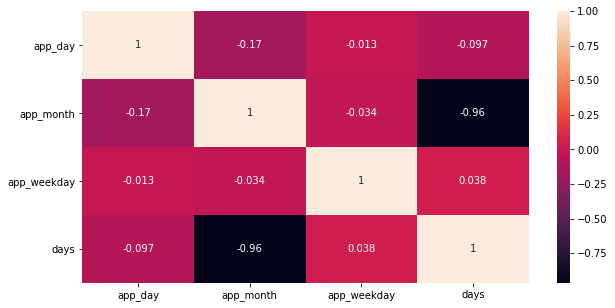

In [15]:
# Смотрим корреляцию:

plt.figure(figsize=(10,5))
sns.heatmap(data.iloc[:,20:].corr(), annot=True)

In [16]:
# app_month сильно коррелирует с days, поэтому его убираем:

data.drop(['app_month'], axis=1, inplace=True)
 
# Также убираем за ненадобностью столбец app_date:

data.drop(["app_date"], axis=1, inplace=True)

## 3.3. Анализ и подготовка данных

### 3.3.0. Списки переменных

In [17]:
# Создаем списки числовых, бинарных и категориальных переменных:

# числовые
num_cols = [
    'age',
    'decline_app_cnt',
    'score_bki',
    'bki_request_cnt',
    'income',
    'app_day',
    'days'
    ]

# бинарные
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"]

# категориальные
cat_cols = [
    'education',
    'region_rating',
    'home_address',
    'work_address',
    'sna',
    'first_time',
    'app_weekday'
    ]                                                

### 3.3.1. Целевой показатель default

<AxesSubplot:>

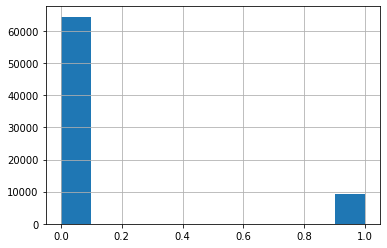

In [18]:
# Смотрим распределение:

data.default.hist()

### 3.3.2. Числовые переменные

#### Значимость

<AxesSubplot:>

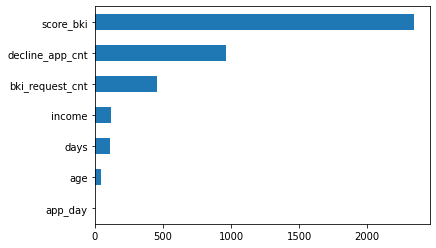

In [19]:
# Определим значимость числовых переменных:

temp = data[data['train'] == 1]
imp_num = pd.Series(f_classif(temp[num_cols], temp['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [20]:
# Дефолт практически не зависит от дня месяца (app_day), убираем этот признак:

data.drop(['app_day'], axis=1, inplace=True)
num_cols.remove('app_day')

#### Переменная score_bki

score_bki
-1.775263        517
-2.104211        454
-2.225004        424
-2.169664        375
-2.024100        278
...              ...
-1.784307          1
-2.216105          1
-1.896095          1
-2.598073          1
-2.296371          1

[102618 rows x 1 columns]

количество уникальных значений =  102618
максимальное значений =  0.19977285
минимальное значений =  -3.62458632


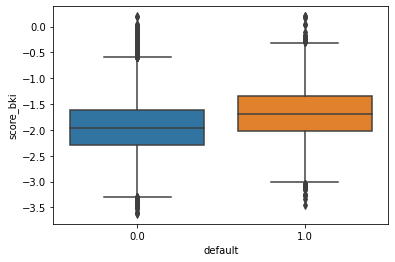

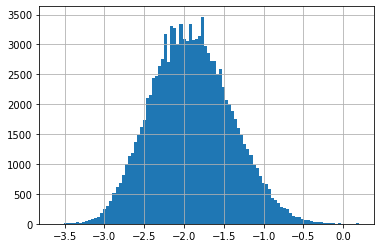

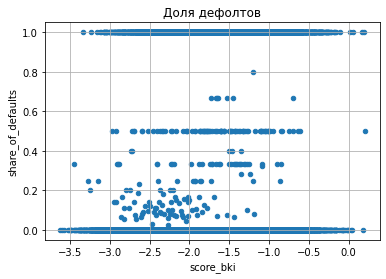

In [21]:
# Вызываем функцию для анализа и визуализации данных в числовых колонках:

i = 'score_bki'
num_column_analysis(i) 

Данные распределены нормально, визуально корреляция с целевой переменной незначительная

#### Переменная decline_app_cnt

decline_app_cnt
0             91471
1             12500
2              3622
3              1365
4               606
5               255
6               156
7                58
8                37
9                29
10               16
11               10
12                5
13                4
14                3
16                3
15                1
19                1
20                1
21                1
22                1
24                1
30                1
33                1

количество уникальных значений =  24
максимальное значений =  33
минимальное значений =  0


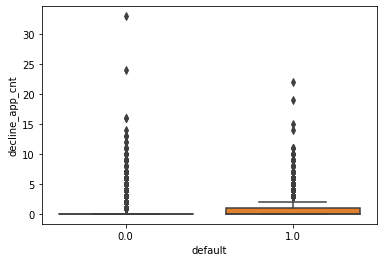

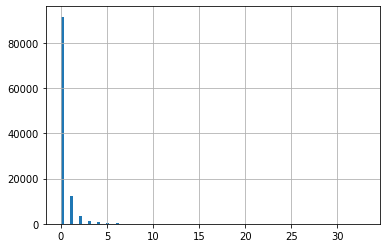

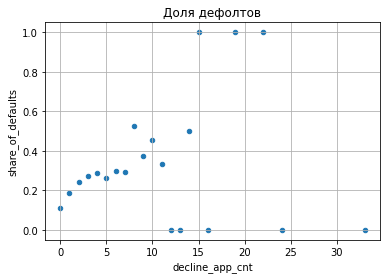

In [22]:
# Вызываем функцию для анализа и визуализации данных в числовых колонках:

i = 'decline_app_cnt'
num_column_analysis(i) 

С ростом показателя до 10 дефолтность растет, а потом начинает вести себя хаотично, количество показателей больших 4 очень мало.

In [23]:
# Для уменьшения выбросов "подожмем хвост" у выборки и переведем признак в категориальный:

data.decline_app_cnt = data.decline_app_cnt.apply(lambda x: (x if x <= 4 else 5))

num_cols.remove('decline_app_cnt')
cat_cols.append('decline_app_cnt')

decline_app_cnt
0            91471
1            12500
2             3622
3             1365
4              606
5              584

количество уникальных значений =  6
максимальное значений =  5
минимальное значений =  0


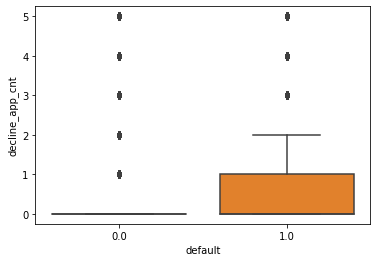

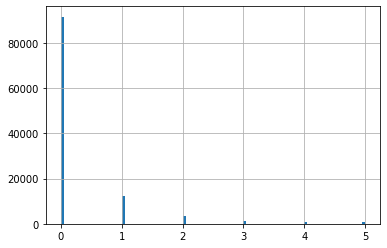

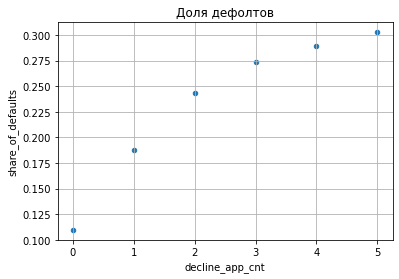

In [24]:
# Смотрим,что получилось:
i = 'decline_app_cnt'
num_column_analysis(i) 

#### Переменная bki_request_cnt

bki_request_cnt
0             28908
1             27295
2             20481
3             13670
4              8406
5              4960
6              2500
7              1292
8               735
9               459
10              350
11              278
12              217
13              151
14              110
15               81
16               58
17               33
18               32
19               30
21               19
20               14
24               12
23               12
22                8
25                5
27                5
28                5
26                4
32                4
29                3
40                2
33                2
36                1
34                1
41                1
45                1
46                1
47                1
53                1

количество уникальных значений =  40
максимальное значений =  53
минимальное значений =  0


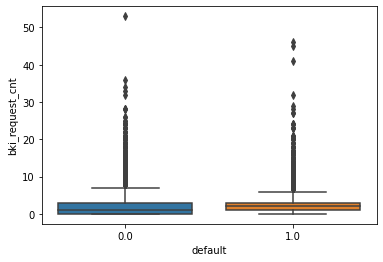

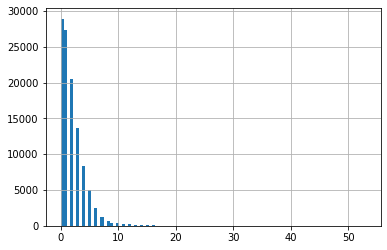

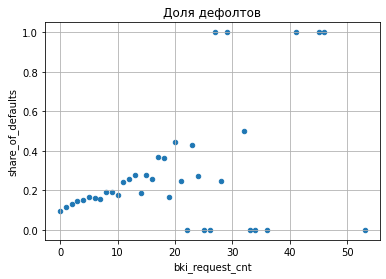

In [25]:
# Вызываем функцию для анализа и визуализации данных в числовых колонках:

i = 'bki_request_cnt'
num_column_analysis(i) 

С ростом показателя примерно до 12 дефолтность растет, а потом начинает вести себя хаотично. Количество показателей больше 10 очень мало.

In [26]:
# Для уменьшения выбросов "подожмем хвост" у выборки и переведем признак в категориальный:

data.bki_request_cnt = data.bki_request_cnt.apply(lambda x: (x if x <= 10 else 11))
num_cols.remove('bki_request_cnt')
cat_cols.append('bki_request_cnt')

bki_request_cnt
0             28908
1             27295
2             20481
3             13670
4              8406
5              4960
6              2500
7              1292
11             1092
8               735
9               459
10              350

количество уникальных значений =  12
максимальное значений =  11
минимальное значений =  0


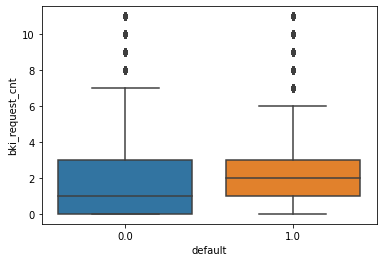

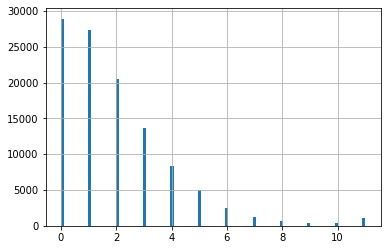

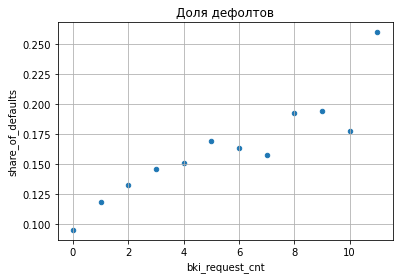

In [27]:
# Смотрим,что получилось:
i = 'bki_request_cnt'
num_column_analysis(i) 

#### Переменная income

income
30000    10437
25000     9090
20000     8174
40000     7383
50000     6742
...        ...
96500        1
14620        1
16723        1
154000       1
32400        1

[1207 rows x 1 columns]

количество уникальных значений =  1207
максимальное значений =  1000000
минимальное значений =  1000


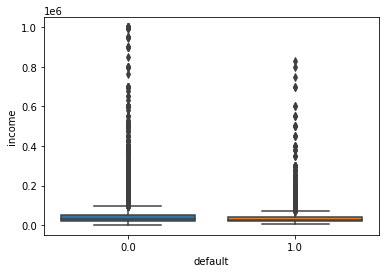

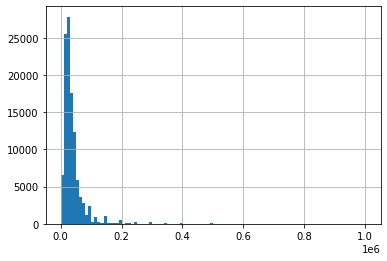

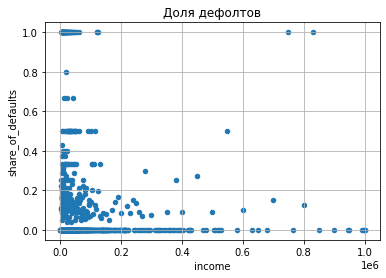

In [28]:
# Вызываем функцию для анализа и визуализации данных в числовых колонках:

i = 'income'
num_column_analysis(i) 

Данные требуют нормализации, визуально корреляции с целевой переменной проявляеся в том, что при низких доходах уровень дефолтности больше, однако эта зависимость весьма сильно размыта.

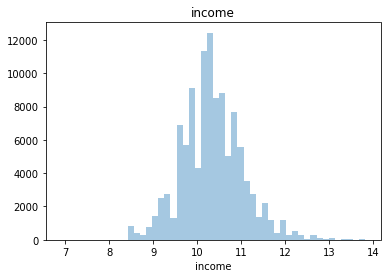

In [29]:
# Нормализуем данные посредством логарифмирования:

i = 'income'

data[i] = data[i].apply(lambda w: np.log(w + 1))
plt.figure()
sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
plt.title(i)
plt.show()

#### Переменная days

days
43   1491
42   1363
44   1350
30   1317
23   1296
..    ...
10    359
113   349
117   313
118   204
119    56

[120 rows x 1 columns]

количество уникальных значений =  120
максимальное значений =  119
минимальное значений =  0


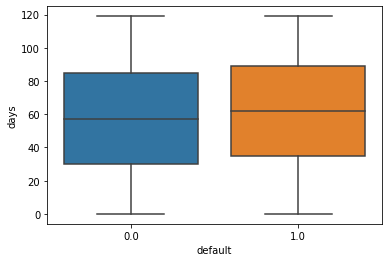

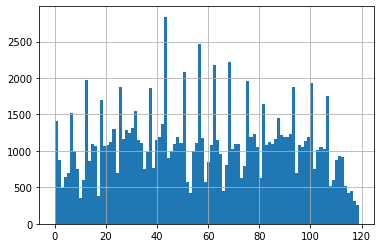

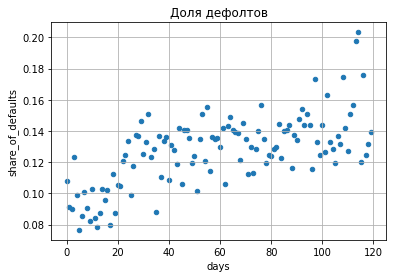

In [30]:
# Вызываем функцию для анализа и визуализации данных в числовых колонках:

i = 'days'
num_column_analysis(i) 

С ростом показателя дефолтность растет, однако кривая роста имеет большую дисперсию. Можно попробовать сгруппировать данные по диапазонам. 

In [31]:
# Сгруппируем показатели, разбив на интервалы по 15 дней и переведем признак в категориальный:

# Функция для группировки:

def days_to_group(days):
    if days <= 15:
        days_group = 0
        return days_group             
    if 15 < days <= 30:
        days_group= 1
        return days_group
    if 30 < days <= 45:
        days_group= 2
        return days_group
    if 45 < days <= 60:
        days_group= 3
        return days_group
    if 60 < days <= 75:
        days_group= 4
        return days_group
    if 50 < days <= 60:
        days_group= 5
        return days_group
    if 75 < days <= 90:
        days_group= 6
        return days_group
    if 90 < days <= 105:
        days_group= 7
        return days_group
    if days > 105:
        days_group = 8
        return days_group

    
data['days'] = data['days'].apply(lambda x:days_to_group(x))
num_cols.remove('days')
cat_cols.append('days')

days
2  15613
1  15295
7  15238
6  15080
3  14667
4  14420
0  12288
8   7547

количество уникальных значений =  8
максимальное значений =  8
минимальное значений =  0


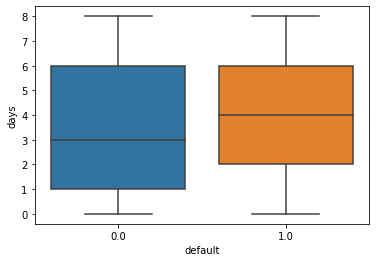

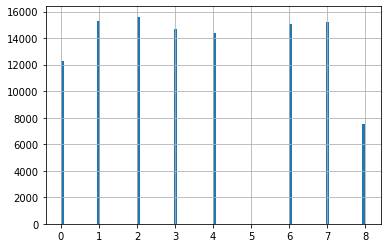

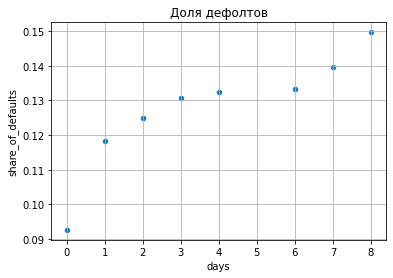

In [32]:
# Смотрим,что получилось:

i = 'days'
num_column_analysis(i) 

#### Переменная age

age
31  4084
30  4035
28  4035
27  3964
29  3940
..   ...
68   261
69   110
70    60
71     6
72     2

[52 rows x 1 columns]

количество уникальных значений =  52
максимальное значений =  72
минимальное значений =  21


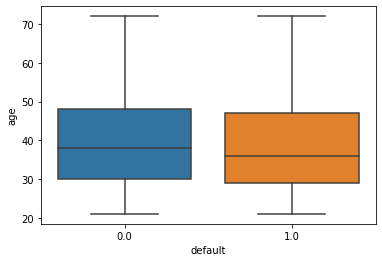

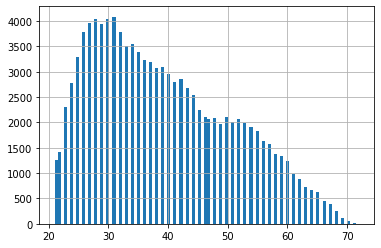

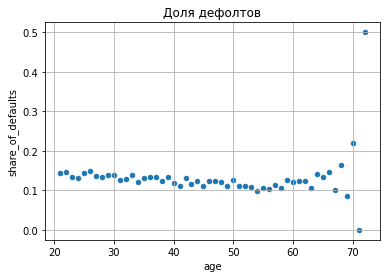

In [33]:
# Вызываем функцию для анализа и визуализации данных в числовых колонках:

i = 'age'
num_column_analysis(i) 

Визуально корреляция с целевым признаком слабая, при увеличении возраста доля дефолтов медленно падает и примерно начиная с 55 лет снова начинает расти.

In [34]:
# Сгруппируем показатели, разбив на интервалы по 10 лет и переведем признак в категориальный:

# Функция для группировки:

def age_to_group(age):
    if age <= 30:
        group_age = 0
        return group_age             
    if 30 < age <= 40:
        group_age = 1
        return group_age
    if 40 < age <= 50:
        group_age = 2
        return group_age
    if 50 < age <= 60:
        group_age = 3
        return group_age
    if age > 60:
        group_age = 4
        return group_age


data['age'] = data['age'].apply(lambda x:age_to_group(x))
num_cols.remove('age')
cat_cols.append('age')

age
1  33818
0  30798
2  23432
3  16976
4   5124

количество уникальных значений =  5
максимальное значений =  4
минимальное значений =  0


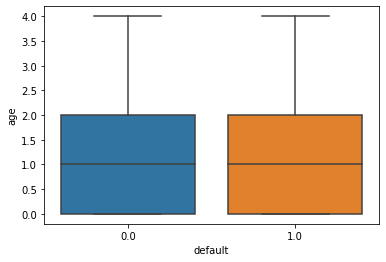

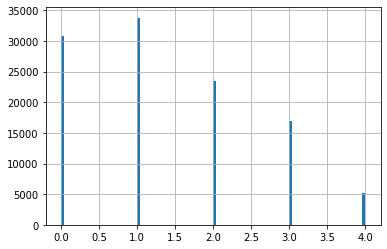

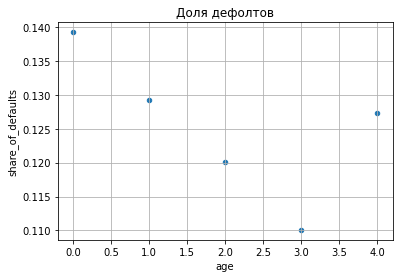

In [35]:
# Смотрим,что получилось:

i = 'age'
num_column_analysis(i) 

#### Корреляции

<AxesSubplot:>

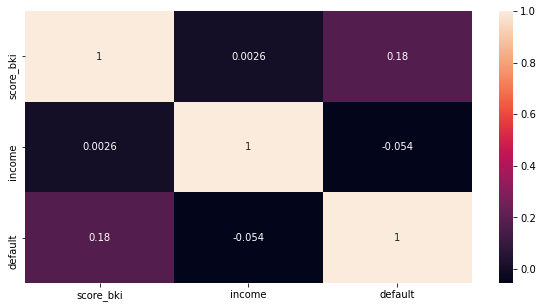

In [36]:
# Посмотрим матрицу корреляций для числовых признаков:
plt.figure(figsize=(10, 5))
sns.heatmap(data[num_cols + ['default']].corr(), annot=True)

Все признаки слабо скоррелированы друг с другом, все можно оставить

<AxesSubplot:>

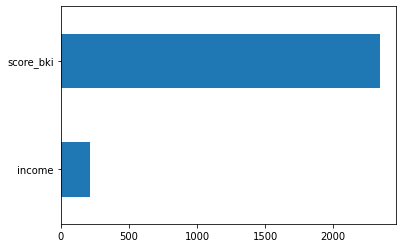

In [37]:
# Определим значимость числовых переменных:

temp = data[data['train'] == 1]
imp_num = pd.Series(f_classif(temp[num_cols], temp['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

### 3.3.3. Бинарные и категориальные переменные

In [38]:
# Для удобства восприятия при визуализации в поле education меняем признаки на числа, 
# большему уровню образования сопоставляем большее число:

education_dict = { 
'SCH' : 0, # SCH (school) школьное образование
'UGR' : 1, # UGR (undergraduate) базовое высшее с получением степени бакалавра
'GRD' : 2, # GRD (graduate) базовое высшее с получением степени магистра
'PGR' : 3, # PGR (postgraduate) профессиональная специализация
'ACD' : 4  # ACD (academic degree)
}

data['education'] = data.apply(lambda row: education_dict[row.education],axis = 1)

display(pd.DataFrame(data['education'].value_counts())) # проверка

education
0      58476
2      34768
1      14748
3       1865
4        291

#### Визуализация

sex
F  61836
M  48312

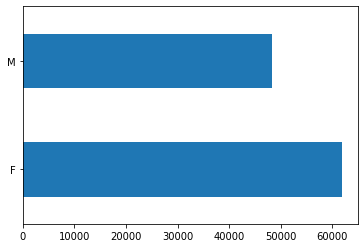

car
N  74290
Y  35858

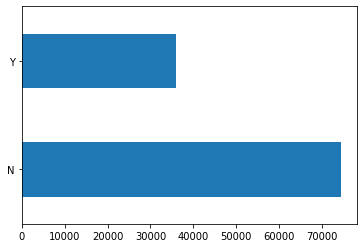

car_type
N     89140
Y     21008

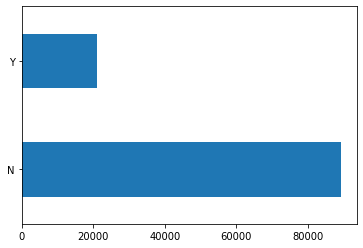

good_work
0      91917
1      18231

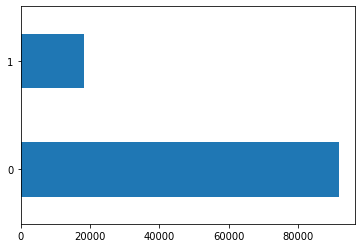

foreign_passport
N             93721
Y             16427

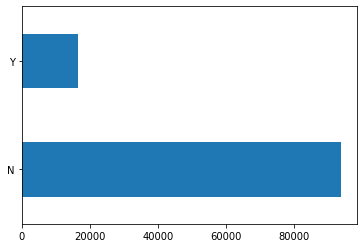

education
0      58476
2      34768
1      14748
3       1865
4        291

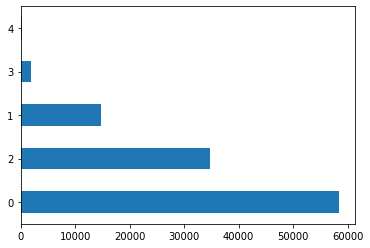

region_rating
50          40981
60          23999
40          17947
80          17170
70           9304
30            434
20            313

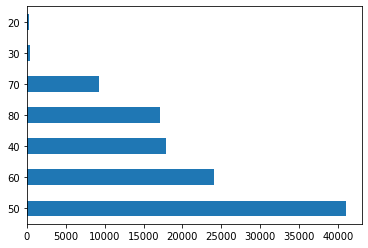

home_address
2         59591
1         48688
3          1869

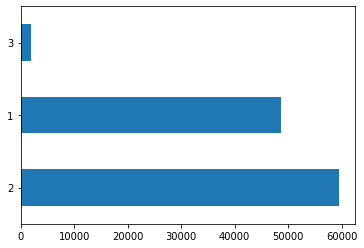

work_address
3         67113
2         30761
1         12274

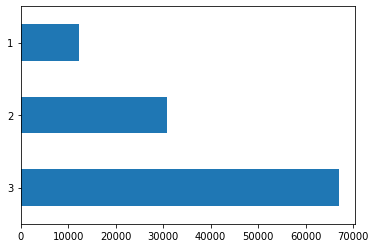

sna
1  70681
4  17481
2  15832
3   6154

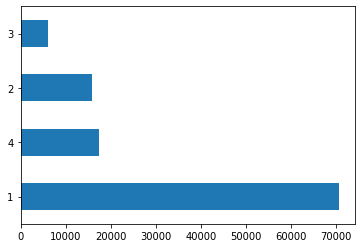

first_time
3       46588
4       28017
1       18296
2       17247

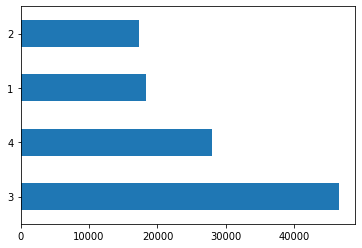

app_weekday
1        18180
0        17858
2        17581
3        17421
4        16749
5        12202
6        10157

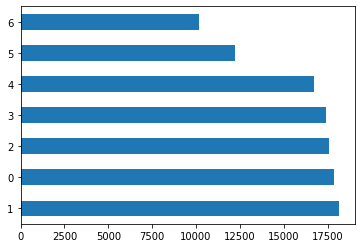

decline_app_cnt
0            91471
1            12500
2             3622
3             1365
4              606
5              584

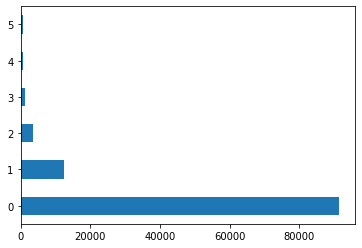

bki_request_cnt
0             28908
1             27295
2             20481
3             13670
4              8406
5              4960
6              2500
7              1292
11             1092
8               735
9               459
10              350

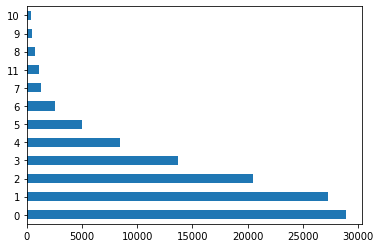

days
2  15613
1  15295
7  15238
6  15080
3  14667
4  14420
0  12288
8   7547

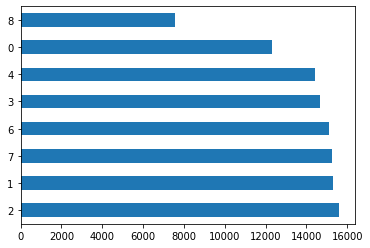

age
1  33818
0  30798
2  23432
3  16976
4   5124

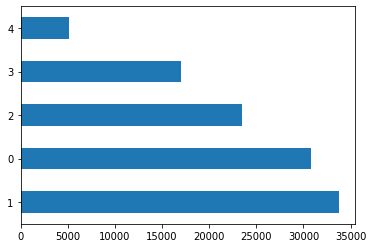

In [39]:
# Смотрим распределения уникальных значений в колонках:

no_num_cols = bin_cols + cat_cols    

for i in no_num_cols: 
    display(pd.DataFrame(data[i].value_counts()))
    data[i].value_counts().plot.barh()
    plt.show()  

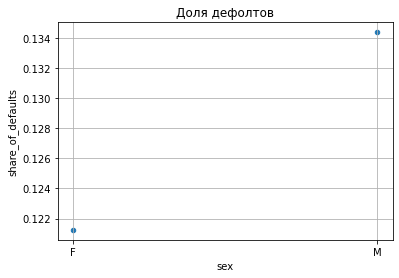

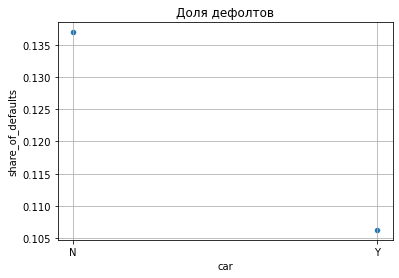

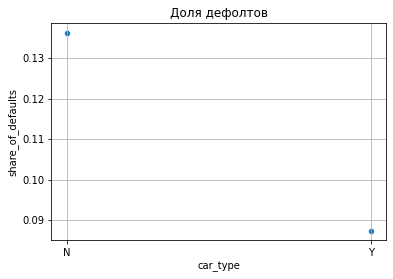

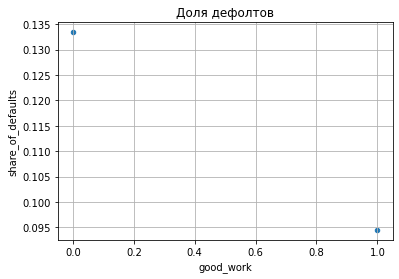

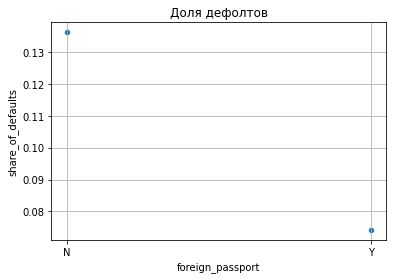

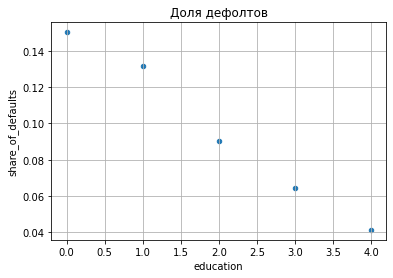

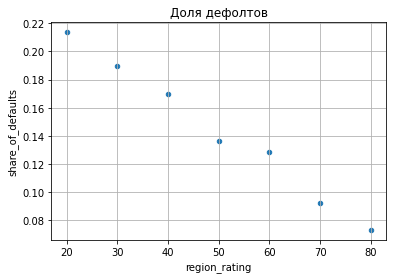

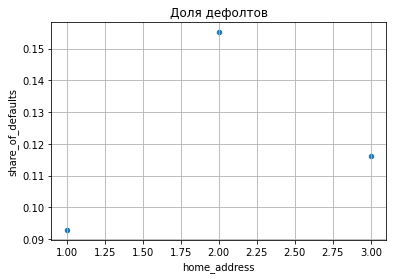

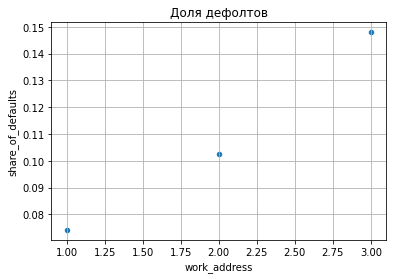

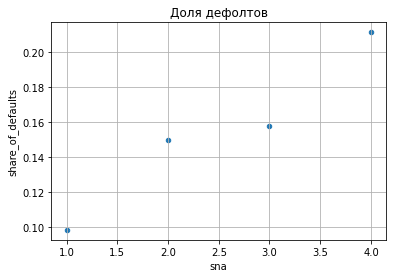

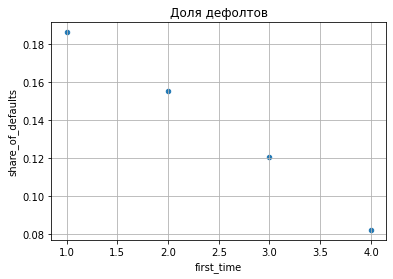

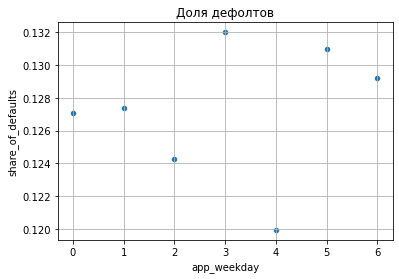

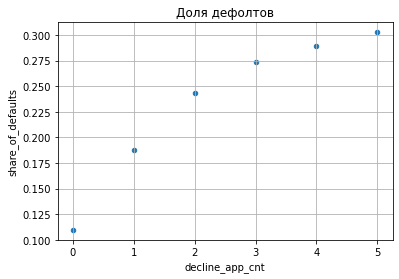

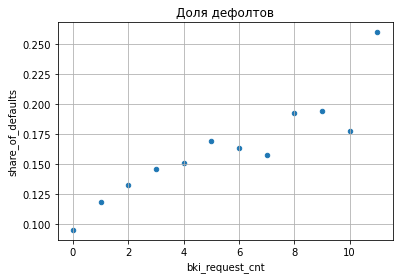

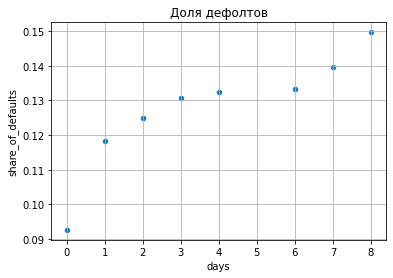

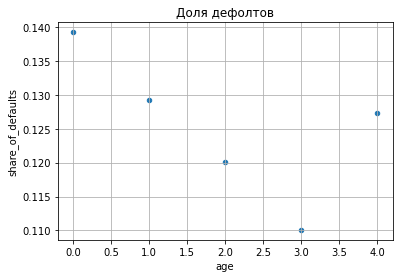

In [40]:
# Смотрим зависимости доли дефолтов и общего количества записей в разрезе уникальных значений колонки:

for i in no_num_cols: 
    share_of_defaults_plot(i)

Изменение доли дефолтов достаточно явно коррелирует с изменением всех бинарных и категориальных переменных, кроме app_weekday

#### Перекодировка данных, определение значимости и корреляции признаков

In [41]:
# Подготовка бинарных переменных:

# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for i in bin_cols:
    data[i] = label_encoder.fit_transform(data[i])
    
data[bin_cols].sample(5) # проверка

sex  car  car_type  good_work  foreign_passport
91011    1    1         1          0                 0
52597    0    0         0          0                 0
46046    0    0         0          0                 1
57776    0    0         0          0                 0
95859    0    1         0          0                 0

Зависимость дефолтности от уровня образования практически линейная

<AxesSubplot:>

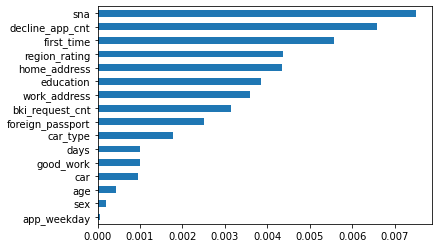

In [42]:
# Посмотрим значимость нечисловых признаков:

temp_cols = no_num_cols
temp = data[data['train'] == 1]
imp_cat = Series(mutual_info_classif(temp[temp_cols],
                 temp['default'], discrete_features=True),
                 index = temp_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

In [43]:
# Дефолт практически не зависит от дня недели, убираем этот признак:

data.drop(['app_weekday'], axis=1, inplace=True)
cat_cols.remove('app_weekday')
no_num_cols.remove('app_weekday')

<AxesSubplot:>

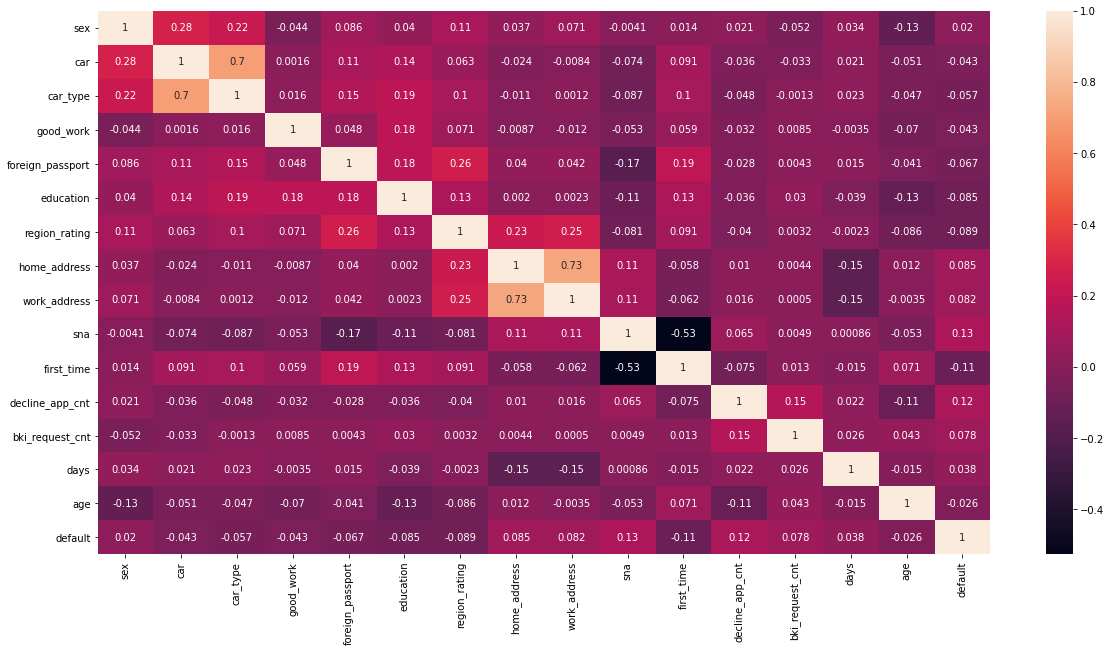

In [44]:
# Посмотрим матрицу корреляций для нечисловых признаков:
plt.figure(figsize=(20, 10))
sns.heatmap(data[no_num_cols + ['default']].corr(), annot=True)

Достаточно сильно скоррелированы пары признаков car и car_type, и home_address и work_address, попробуем создать объединяющие пары признаки car и addresses.

In [45]:
# Объединяем признаки car и car_type в один признак car:

# Функция для получения объединенного признака:
def combining_types_car(row):

    result = row['car'] + row['car_type'] 
    return result
# в итоге получаем: если 0, то машины нет, если 1 - то есть отечественная, если 2 - то есть иномарка
  

data['car'] = data.apply(lambda row: combining_types_car(row), axis=1)


bin_cols.remove('car_type')
no_num_cols.remove('car_type') 
data.drop(['car_type'], axis=1, inplace=True)

car
0.0  74290
2.0  21008
1.0  14850

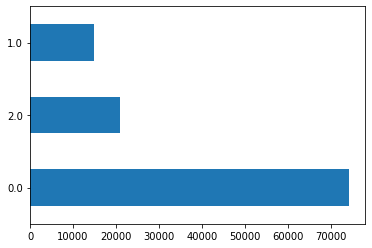

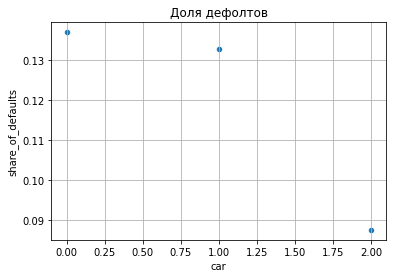

In [46]:
# Посмотрим, что получилось:
i = 'car'
display(pd.DataFrame(data[i].value_counts()))
data[i].value_counts().plot.barh()
plt.show() 
share_of_defaults_plot(i)

In [47]:
# Объединяем признаки home_address и work_address в один признак addresses:

# Функция для получения объединенного признака:
def combining_types_adr(row):

    result = 10*row['home_address'] + row['work_address'] 
    return result

  
data['addresses'] = data.apply(lambda row: combining_types_adr(row), axis=1)

cat_cols.append('addresses')
no_num_cols.append('addresses')

cat_cols.remove('home_address')
no_num_cols.remove('home_address') 
data.drop(['home_address'], axis=1, inplace=True)

cat_cols.remove('work_address')
no_num_cols.remove('work_address') 
data.drop(['work_address'], axis=1, inplace=True)

addresses
23.0      57609
12.0      29066
11.0      11832
13.0       7790
33.0       1714
22.0       1574
21.0        408
32.0        121
31.0         34

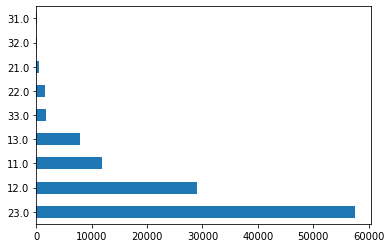

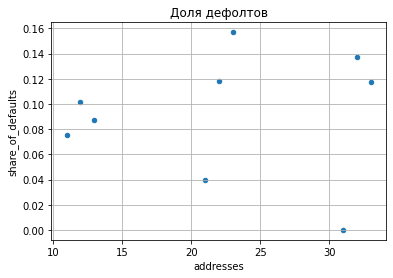

In [48]:
# Посмотрим, что получилось:
i = 'addresses'
display(pd.DataFrame(data[i].value_counts()))
data[i].value_counts().plot.barh()
plt.show() 
share_of_defaults_plot(i)

<AxesSubplot:>

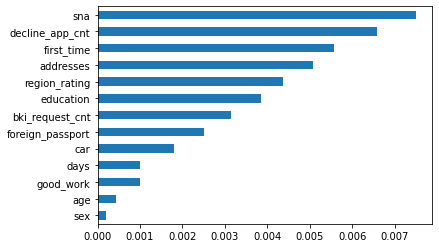

In [49]:
# Посмотрим снова на значимость переменных:

temp_cols = no_num_cols
temp = data[data['train'] == 1]
imp_cat = Series(mutual_info_classif(temp[temp_cols],
                 temp['default'], discrete_features=True),
                 index = temp_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

<AxesSubplot:>

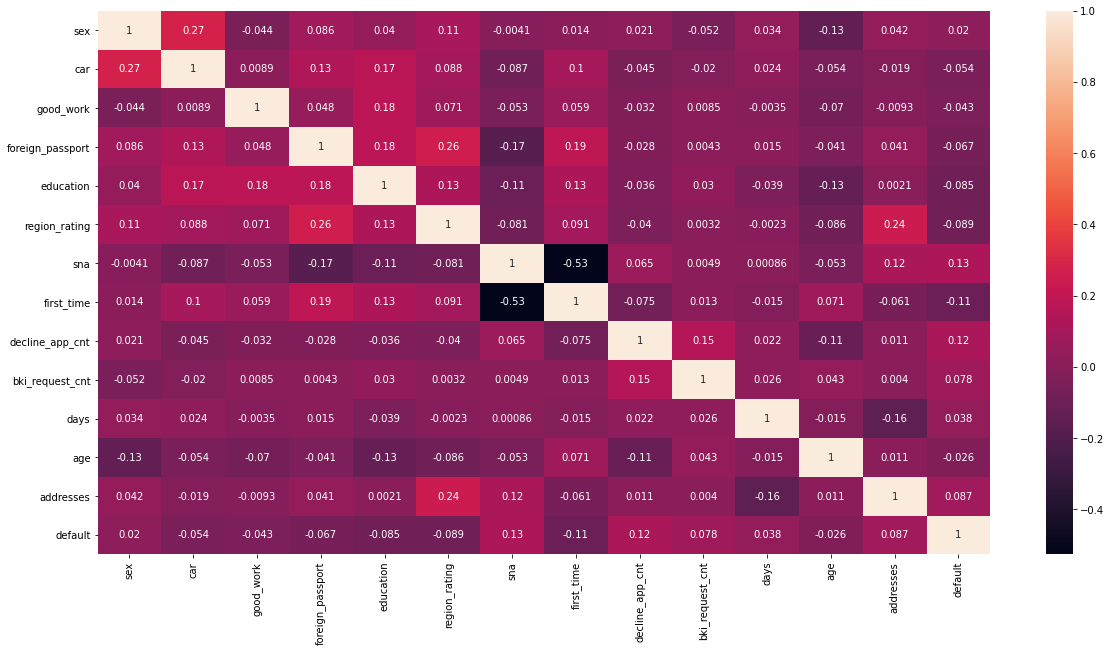

In [50]:
# И матрицу корреляций для нечисловых признаков:
plt.figure(figsize=(20, 10))
sns.heatmap(data[no_num_cols + ['default']].corr(), annot=True)

# 4. Построение модели

## 4.0. Модель версия 0. Базовая

### Подготовка данных и обучение модели

In [51]:
# Делим датасет на тест и трейн:

train = data.query('train == 1').drop(['train'], axis=1)
test = data.query('train == 0').drop(['train'], axis=1)

In [52]:
# Проверим на соответствие значений:

print('Размер тренировочного датасета: ', train.shape,
      'Размер тестового датасета: ', test.shape, sep='\n')

Размер тренировочного датасета: 
(73799, 17)
Размер тестового датасета: 
(36349, 17)


Количество строк соответствует исходным.

In [53]:
# Проводим OneHot-кодирование категориальных переменных:

X_cat = OneHotEncoder(sparse=False).fit_transform(train[cat_cols].values)

In [54]:
# Стандартизируем числовые переменные:

X_num = StandardScaler().fit_transform(train[num_cols].values)

In [55]:
# Объединяем числовые, бинарные и категориальные переменные в одно признаковое пространство,
# разделив при этом признаки и целевую переменную:

X = np.hstack([X_num, train[bin_cols].values,X_cat])
Y = train['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [56]:
# Обучаем модель:

model_0 = LogisticRegression(solver = 'liblinear', max_iter = 1000)
model_0.fit(X_train, y_train)
y_pred = model_0.predict(X_test)

### Метрики качества

#### Стандартные метрики

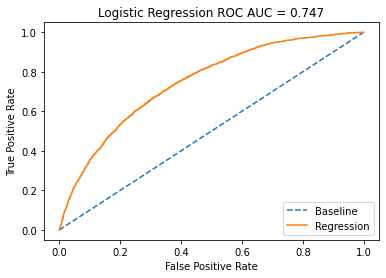

In [57]:
# Logistic Regression ROC AUC:

probs = model_0.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

array([[12866,    67],
       [ 1783,    44]])

<AxesSubplot:>

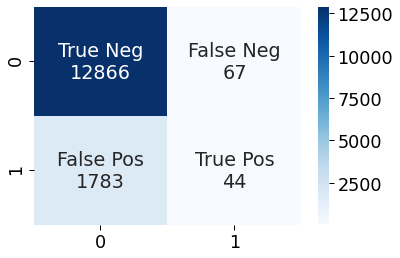

In [58]:
# Confusion matrix:

CM = confusion_matrix(y_test, y_pred)
display(CM)

sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Neg', 'False Pos', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')

**ВЫВОДЫ:** Модель хорошо предсказывает недефолтных клиентов, но очень плохо - дефолтных, это является следствием разбалансировки данных (в выборке мало дефолтных клиентов). Необходим oversampling.

In [59]:
# Прочие:

print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

accuracy_score: 0.8747
f1_score: 0.0454
recall_score: 0.0241
MSE: 0.1253


#### Бизнес-метрика

Бизнес-задача максимизировать прибыль, т.е., грубо, разницу между выручкой и потерями. 
Пусть: 
* s - средний размер кредита,
* N - количество клиентов, подавших заявки на кредит,
* i - средняя выручка от одного кредита за срок жизни в % от суммы кредита, 
* l - средние потери от одного дефолта в % от суммы кредита (она не равна 100%, т.к. не все кредиты уходят в дефолт сразу + дефолтные кредиты за небольшой процент можно продать коллекторскому агенству), 
* f - доля  дефолтных клиентов,
* k - доля получивших кредит качественных клиентов.
* r - доля получивших кредит дефотных клиентов.

Тогда максимально возможная прибыль равна 
$$
Pmax = N*s*(1-f)*i,
$$
а реальная прибыль
$$
P = N*s*((1-f)*i*k - f*l*r)
$$

Метрикой качества в данном случае будет отношение P к Pmax, назовем ее BM (от Business Metric):
$$
BM = P/Pmax = k - f*l*r/(1-f)/i
$$

В терминах стандартных метрик часть коэффициентов можно определить так:
$$
f = (TP + FP)/(TP + FP + TN + FN),
$$
$$
k = TN/(TN + FN),
$$
$$
r = FP/(FP + TP).
$$

Тогда 
$$
BM = k - (l/i)*f/(1-f)*r = 
$$

Подставляя все в формулу для M после преобразований получим:
$$
BM = (TN - (l/i)*FP)/(TN + FN)
$$
Принимая для определенности i = 25% (грубо 10% годовых маржи на 3 года с учетом постепенного погашения), а l = 75%, получим в нашем случае 
$$
BM = (TN - 3*FP)/(TN + FN)
$$

In [60]:
# Считаем бизнес-метрику:

TN = CM[0,0]
FN = CM[0,1]
FP = CM[1,0]
BM = (TN - 3*FP)/(TN + FN)
print('BM: {}'.format(np.round(BM, 4)))

BM: 0.5812


## 4.1. Модель версия 1. Базовая + oversampling

In [61]:
# Произведем простейший oversampling посредством дублирования строк с дефолтом:

zeros = train[train['default'] == 0]
ones = train[train['default'] == 1]
default_new = int(len(zeros) / len(ones))
for i in range(default_new):
    train1 = train.append(ones).reset_index(drop=True)

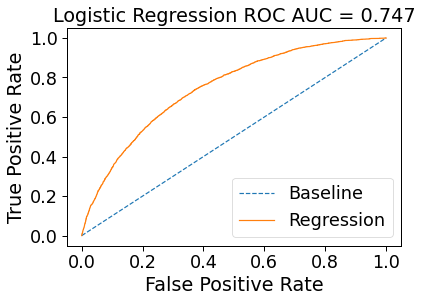

array([[12409,   449],
       [ 3169,   608]])

BM: 0.2257
accuracy_score: 0.7825
f1_score: 0.2516
recall_score: 0.161
MSE: 0.2175


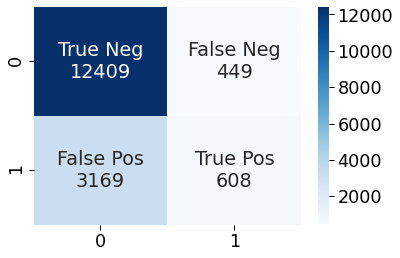

In [62]:
# Подготавливаем данные:

X_cat = OneHotEncoder(sparse = False).fit_transform(train1[cat_cols].values)
X_num = StandardScaler().fit_transform(train1[num_cols].values)
X = np.hstack([X_num, train1[bin_cols].values, X_cat])
Y = train1['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

#Обучаем модель:

model_1 = LogisticRegression(solver = 'liblinear', max_iter = 2000)
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)

# Считаем метрики:

# Logistic Regression ROC AUC:

probs = model_1.predict_proba(X_test)
probs = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Confusion matrix:

CM = confusion_matrix(y_test, y_pred)
display(CM)
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Neg', 'False Pos', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')


# Бизнес-метрика:

TN = CM[0,0]
FN = CM[0,1]
FP = CM[1,0]
BM = (TN - 3*FP)/(TN + FN)
print('BM: {}'.format(np.round(BM, 4)))

# Прочие:

print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))


ROC AUC не изменился, доля определения дефолтных клиентов выросла, но вместе с ней уменьшилась и доля определения хороших клиентов, что по совокупности дало негативный результат - бизнес-метрика BM стала хуже.

## 4.2. Модель версия 2. Базовая + полиноминальные признаки

Попробуем еще улучшить модель посредством добавления полиноминальных признаков.

In [63]:
# Добавим полиномиальные признаки на основе числовых признаков.

pf = PolynomialFeatures(2, include_bias=False)
poly_data = pf.fit_transform(data[num_cols])[:, len(num_cols):]
poly_cols = pf.get_feature_names()[len(num_cols):]
poly_df = pd.DataFrame(poly_data, columns=poly_cols)
data = data.join(poly_df, how='left')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  int64  
 2   sex               110148 non-null  int64  
 3   age               110148 non-null  int64  
 4   car               110148 non-null  float64
 5   decline_app_cnt   110148 non-null  int64  
 6   good_work         110148 non-null  int64  
 7   score_bki         110148 non-null  float64
 8   bki_request_cnt   110148 non-null  int64  
 9   region_rating     110148 non-null  int64  
 10  income            110148 non-null  float64
 11  sna               110148 non-null  int64  
 12  first_time        110148 non-null  int64  
 13  foreign_passport  110148 non-null  int64  
 14  default           73799 non-null   float64
 15  train             110148 non-null  int64  
 16  days              11

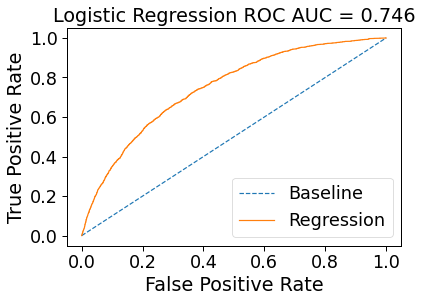

array([[12872,    61],
       [ 1784,    43]])

BM: 0.5815
accuracy_score: 0.875
f1_score: 0.0445
recall_score: 0.0235
MSE: 0.125


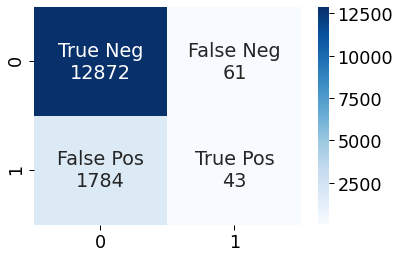

In [64]:
# Подготавливаем данные:

train = data.query('train == 1').drop(['train'], axis=1)
test = data.query('train == 0').drop(['train'], axis=1)

X_cat = OneHotEncoder(sparse=False).fit_transform(train[cat_cols].values)
X_num = StandardScaler().fit_transform(train[num_cols].values)

X = np.hstack([X_num, train[bin_cols].values, train[poly_cols].values, X_cat])
Y = train['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

#Обучаем модель:

model_2 = LogisticRegression(solver = 'liblinear', max_iter = 2000)
model_2.fit(X_train, y_train)
y_pred = model_2.predict(X_test)

# Считаем метрики:

# Logistic Regression ROC AUC:

probs = model_2.predict_proba(X_test)
probs = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Confusion matrix:

CM = confusion_matrix(y_test, y_pred)
display(CM)
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Neg', 'False Pos', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')


# Бизнес-метрика:

TN = CM[0,0]
FN = CM[0,1]
FP = CM[1,0]
BM = (TN - 3*FP)/(TN + FN)
print('BM: {}'.format(np.round(BM, 4)))

# Прочие:

print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

В принципе ничего не изменилось, ROC AUC стал чуть-чуть хуже, а бизнес-метрика BM стала чуть-чуть лучше.

## 4.3. Модель версия 3. Базовая + полиноминальные признаки + настройка гиперпараметров

Попробуем улучшить модель подбором гиперпараметров

In [65]:
# Подбор лучших гиперпараметров для модели

from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(solver = 'liblinear', max_iter = 2000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l1
Лучшее C: 464.15888336127773


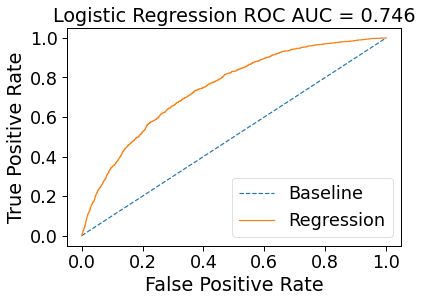

array([[8679, 4254],
       [ 573, 1254]])

BM: 0.5382
accuracy_score: 0.673
f1_score: 0.3419
recall_score: 0.6864
MSE: 0.327


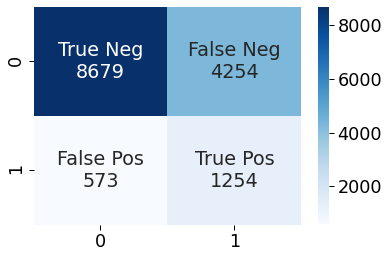

In [66]:
# Обучаем модель с лучшими гиперпараметрами:

model_3 = LogisticRegression(penalty='l1', class_weight='balanced', max_iter=500, solver = 'liblinear', C = 7.74)
model_3.fit(X_train, y_train)
y_pred = model_3.predict(X_test)

# Считаем метрики:

# Logistic Regression ROC AUC:

probs = model_3.predict_proba(X_test)
probs = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Confusion matrix:

CM = confusion_matrix(y_test, y_pred)
display(CM)
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Neg', 'False Pos', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')


# Бизнес-метрика:

TN = CM[0,0]
FN = CM[0,1]
FP = CM[1,0]
BM = (TN - 3*FP)/(TN + FN)
print('BM: {}'.format(np.round(BM, 4)))

# Прочие:

print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

ROC AUC не изменился, доля определения дефолтных клиентов сильно выросла, но вместе с ней сильно уменьшилась и доля определения хороших клиентов, что по совокупности дало негативный результат - бизнес-метрика BM стала хуже.

# 5. Данные для соревнования

In [67]:
X_cat_test = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)
X_num_test = StandardScaler().fit_transform(test[num_cols].values)
X_test2 = np.hstack([X_num_test, test[bin_cols].values, test[poly_cols].values, X_cat_test])

y_probs = model_2.predict_proba(X_test2)[:,1]

test['default'] = y_probs
submission = test[['client_id','default']]
display(submission.sample(10))
display(submission.shape)

submission.to_csv('submission.csv', index=False)

client_id   default
106559      42602  0.155297
90236       40115  0.376123
88787      108764  0.066269
98799       59858  0.290410
99268       99234  0.033190
108860      48536  0.148247
95109       45215  0.048892
80256       28222  0.042943
92054       20534  0.167884
90513      102321  0.107974

(36349, 2)